In [1]:
!pip install torch torchvision torchaudio
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.2/69.2 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 54.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.9/274.9 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.0/129.0 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.1/231.1 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 344.1/344.1 kB 22.3 MB/s eta 0:00:00


In [2]:
import torch
import numpy as np
import scipy.sparse as sp
from torch_geometric.datasets import Planetoid
def load_data(dataset_name):
    dataset = Planetoid(root='/tmp/dataset', name=dataset_name)
    data = dataset[0]

    features = data.x.numpy()
    edge_index = data.edge_index.numpy()
    num_nodes = data.num_nodes

    row, col = edge_index
    values = np.ones(len(row))
    adj = sp.coo_matrix((values, (row, col)), shape=(num_nodes, num_nodes), dtype=np.float32)
    adj = adj + sp.eye(num_nodes)

    labels = data.y.numpy()
    train_mask = data.train_mask.numpy()
    val_mask = data.val_mask.numpy()
    test_mask = data.test_mask.numpy()

    features_tensor = torch.tensor(features, dtype=torch.float32, device="cpu")
    adj_tensor = torch.tensor(adj.toarray(), dtype=torch.float32, device="cpu")
    labels_tensor = torch.tensor(labels, dtype=torch.long, device="cpu")
    train_mask_tensor = torch.tensor(train_mask, dtype=torch.bool, device="cpu")
    val_mask_tensor = torch.tensor(val_mask, dtype=torch.bool, device="cpu")
    test_mask_tensor = torch.tensor(test_mask, dtype=torch.bool, device="cpu")
    return features_tensor, adj_tensor, labels_tensor, train_mask_tensor, val_mask_tensor, test_mask_tensor

In [3]:
import numpy as np
import scipy.sparse as sp
import torch
from torch_geometric.datasets import Planetoid
from torch_geometric.loader import NeighborLoader

def load_pubmed():
    dataset = Planetoid(root='/tmp/dataset', name="PubMed")
    data = dataset[0]

    num_nodes = data.num_nodes

    edge_index = data.edge_index
    features = data.x.to("cpu")
    labels = data.y.to("cpu")
    train_mask = data.train_mask.to("cpu")
    val_mask = data.val_mask.to("cpu")
    test_mask = data.test_mask.to("cpu")

    train_loader = NeighborLoader(
        data,
        num_neighbors=[10, 5],
        batch_size=1024,
        input_nodes=train_mask,
    )

    return features, labels, train_mask, val_mask, test_mask, train_loader


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GraphAttentionLayer(nn.Module):
    def __init__(self, in_features, out_features, dropout=0.6, alpha=0.2):
        super(GraphAttentionLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.alpha = alpha
        self.dropout = nn.Dropout(dropout)

        self.W = nn.Linear(in_features, out_features, bias=False)

        self.a = nn.Parameter(torch.zeros(size=(2 * out_features, 1)))
        nn.init.xavier_uniform_(self.a.data, gain=1.414)

        self.leakyrelu = nn.LeakyReLU(self.alpha)

    def forward(self, h, adj):
        Wh = self.W(h)

        num_nodes = h.shape[0]
        Wh_i = Wh.repeat(1, num_nodes).view(num_nodes * num_nodes, -1)
        Wh_j = Wh.repeat(num_nodes, 1)
        e = self.leakyrelu(torch.matmul(torch.cat([Wh_i, Wh_j], dim=1), self.a).view(num_nodes, num_nodes))

        attention = torch.where(adj > 0, e, torch.full_like(e, -1e9))
        attention = F.softmax(attention, dim=1)
        attention = self.dropout(attention)

        h_prime = torch.matmul(attention, Wh)

        return F.elu(h_prime)

In [5]:
class MultiHeadGATLayer(nn.Module):
    def __init__(self, in_features, out_features, num_heads=8, dropout=0.6, alpha=0.2, concat=True):
        super(MultiHeadGATLayer, self).__init__()
        self.num_heads = num_heads
        self.concat = concat

        self.attention_heads = nn.ModuleList([
            GraphAttentionLayer(in_features, out_features, dropout, alpha) for _ in range(num_heads)
        ])

    def forward(self, h, adj):
        head_outputs = [head(h, adj) for head in self.attention_heads]

        if self.concat:
            return torch.cat(head_outputs, dim=1)
        else:
            return torch.mean(torch.stack(head_outputs), dim=0)

In [6]:
class GAT(nn.Module):
    def __init__(self, num_features, hidden_units, num_classes, num_heads=8, dropout=0.6, alpha=0.2):
        super(GAT, self).__init__()

        self.dropout = nn.Dropout(dropout)

        self.gat1 = MultiHeadGATLayer(num_features, hidden_units, num_heads, dropout, alpha, concat=True)

        self.gat2 = MultiHeadGATLayer(hidden_units * num_heads, num_classes, num_heads=1, dropout=dropout, alpha=alpha, concat=False)

    def forward(self, x, adj):
        x = self.dropout(x)
        x = self.gat1(x, adj)
        x = self.dropout(x)
        x = self.gat2(x, adj)
        return F.log_softmax(x, dim=1)

In [8]:
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

import gc
def train_and_evaluate(dataset_name, mini_batch):
    print(dataset_name)
    if mini_batch:
        print("Mini Batch")
        features, adj, labels, train_mask, val_mask, test_mask = load_pubmed()
    else:
        features, adj, labels, train_mask, val_mask, test_mask = load_data(dataset_name)
    num_features = features.shape[1]
    num_classes = len(labels.unique())

    gat = GAT(
        num_features=num_features,
        hidden_units=8,
        num_classes=num_classes,
        num_heads=8,
        dropout=0.6,
        alpha=0.2
    )

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    gat = gat.to(device)
    features = features.to(device)
    adj = adj.to(device)
    labels = labels.to(device)
    train_mask = train_mask.to(device)
    val_mask = val_mask.to(device)
    test_mask = test_mask.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(gat.parameters(), lr=0.005, weight_decay=5e-4)

    epochs = 200
    train_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        gat.train()
        optimizer.zero_grad()

        output = gat(features, adj)

        loss = criterion(output[train_mask], labels[train_mask])
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        # gat.eval()
        # with torch.no_grad():
        #     val_output = gat(features, adj)
        #     val_predictions = val_output[val_mask].argmax(dim=1)
        #     val_labels = labels[val_mask]
        #     val_accuracy = (val_predictions == val_labels).sum().item() / val_mask.sum().item()
        #     val_accuracies.append(val_accuracy)

        if epoch % 10 == 0:
            print(f"Epoch {epoch}: Train Loss = {loss.item():.4f}")

        # del output, val_output, val_predictions
        # torch.cuda.empty_cache()
        # gc.collect()

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Training Loss Curve ({dataset_name})")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label="Validation Accuracy", color='orange')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"Validation Accuracy Curve ({dataset_name})")
    plt.legend()

    plt.show()

    gat.eval()
    with torch.no_grad():
        test_output = gat(features, adj)
        test_predictions = test_output[test_mask].argmax(dim=1)
        test_labels = labels[test_mask]
        test_accuracy = (test_predictions == test_labels).sum().item() / test_mask.sum().item()

    print(f"Test Accuracy on {dataset_name}: {test_accuracy:.4f}")


cora
Epoch 0: Train Loss = 1.9400, Val Accuracy = 0.6120
Epoch 10: Train Loss = 1.3479, Val Accuracy = 0.7600
Epoch 20: Train Loss = 0.8282, Val Accuracy = 0.7940
Epoch 30: Train Loss = 0.7222, Val Accuracy = 0.7760
Epoch 40: Train Loss = 0.5998, Val Accuracy = 0.7800
Epoch 50: Train Loss = 0.6220, Val Accuracy = 0.7760
Epoch 60: Train Loss = 0.5262, Val Accuracy = 0.7800
Epoch 70: Train Loss = 0.4407, Val Accuracy = 0.7740
Epoch 80: Train Loss = 0.4553, Val Accuracy = 0.7740
Epoch 90: Train Loss = 0.5393, Val Accuracy = 0.7740
Epoch 100: Train Loss = 0.4799, Val Accuracy = 0.7820
Epoch 110: Train Loss = 0.3594, Val Accuracy = 0.7820
Epoch 120: Train Loss = 0.3824, Val Accuracy = 0.7860
Epoch 130: Train Loss = 0.4836, Val Accuracy = 0.7820
Epoch 140: Train Loss = 0.4932, Val Accuracy = 0.7820
Epoch 150: Train Loss = 0.4605, Val Accuracy = 0.7860
Epoch 160: Train Loss = 0.3729, Val Accuracy = 0.7800
Epoch 170: Train Loss = 0.2956, Val Accuracy = 0.7760
Epoch 180: Train Loss = 0.3950, Va

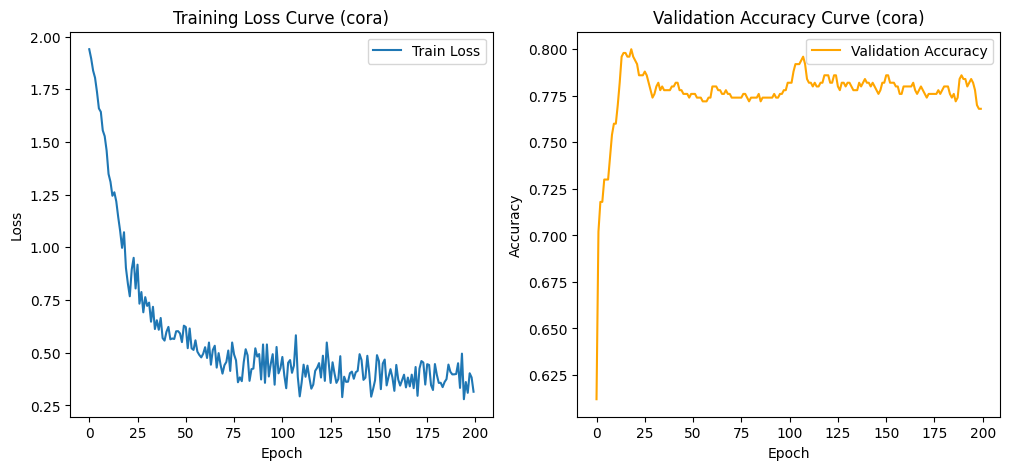

Test Accuracy on cora: 0.8070


In [7]:
train_and_evaluate("cora", False)

CiteSeer
Epoch 0: Train Loss = 1.7928, Val Accuracy = 0.4840
Epoch 10: Train Loss = 1.2021, Val Accuracy = 0.7000
Epoch 20: Train Loss = 0.7818, Val Accuracy = 0.6840
Epoch 30: Train Loss = 0.5651, Val Accuracy = 0.6680
Epoch 40: Train Loss = 0.6664, Val Accuracy = 0.6620
Epoch 50: Train Loss = 0.5762, Val Accuracy = 0.6740
Epoch 60: Train Loss = 0.6911, Val Accuracy = 0.6660
Epoch 70: Train Loss = 0.4904, Val Accuracy = 0.6660
Epoch 80: Train Loss = 0.6215, Val Accuracy = 0.6760
Epoch 90: Train Loss = 0.5441, Val Accuracy = 0.6700
Epoch 100: Train Loss = 0.6271, Val Accuracy = 0.6680
Epoch 110: Train Loss = 0.4701, Val Accuracy = 0.6620
Epoch 120: Train Loss = 0.5968, Val Accuracy = 0.6740
Epoch 130: Train Loss = 0.5430, Val Accuracy = 0.6780
Epoch 140: Train Loss = 0.5558, Val Accuracy = 0.6740
Epoch 150: Train Loss = 0.5649, Val Accuracy = 0.6760
Epoch 160: Train Loss = 0.4011, Val Accuracy = 0.6680
Epoch 170: Train Loss = 0.3658, Val Accuracy = 0.6720
Epoch 180: Train Loss = 0.5429

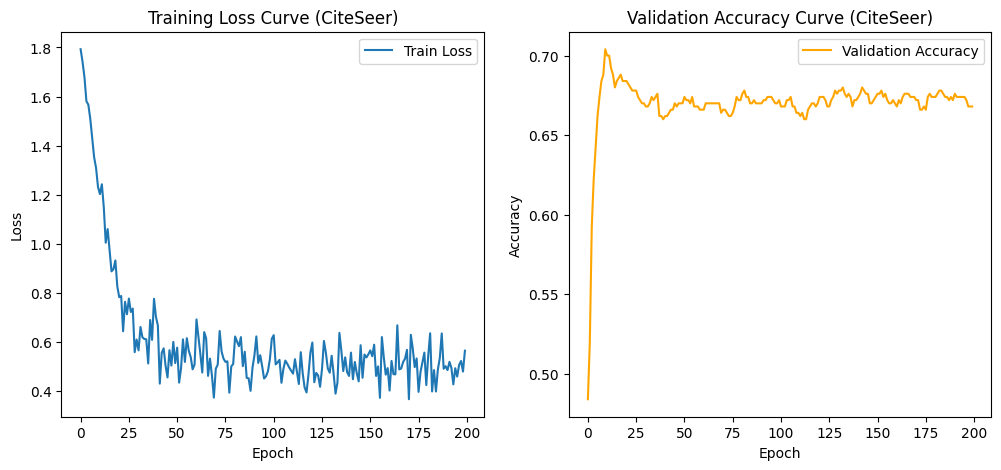

Test Accuracy on CiteSeer: 0.6630


In [8]:
train_and_evaluate("CiteSeer", False)


In [ ]:
!ps aux | grep python
!kill -9 6909

root          84  0.5  0.0      0     0 ?        Z    06:57   0:13 [python3] <defunct>
root          85  0.0  0.0  63780 50980 ?        S    06:57   0:00 python3 /usr/local/bin/colab-file
root         134  0.2  0.1 775772 124120 ?       Sl   06:57   0:04 /usr/bin/python3 /usr/local/bin/j
root        6909 16.6  1.6 52619536 1467076 ?    Ssl  07:23   1:55 /usr/bin/python3 -m colab_kernel_
root        6940  0.2  0.0 545072 20828 ?        Sl   07:23   0:01 /usr/bin/python3 /usr/local/lib/p
root        9997  0.0  0.0   7376  3372 ?        S    07:35   0:00 /bin/bash -c ps aux | grep python
root        9999  0.0  0.0   6484  2324 ?        S    07:35   0:00 grep python


PubMed


Processing...
Done!


Epoch 0: Train Loss = 1.0975
Epoch 10: Train Loss = 1.0298
Epoch 20: Train Loss = 0.9098
Epoch 30: Train Loss = 0.8146
Epoch 40: Train Loss = 0.6319
Epoch 50: Train Loss = 0.5757
Epoch 60: Train Loss = 0.5605
Epoch 70: Train Loss = 0.3845
Epoch 80: Train Loss = 0.4821
Epoch 90: Train Loss = 0.4439
Epoch 100: Train Loss = 0.4395
Epoch 110: Train Loss = 0.4228
Epoch 120: Train Loss = 0.4616
Epoch 130: Train Loss = 0.3449
Epoch 140: Train Loss = 0.3420
Epoch 150: Train Loss = 0.4097
Epoch 160: Train Loss = 0.3083
Epoch 170: Train Loss = 0.3261
Epoch 180: Train Loss = 0.3419
Epoch 190: Train Loss = 0.3174


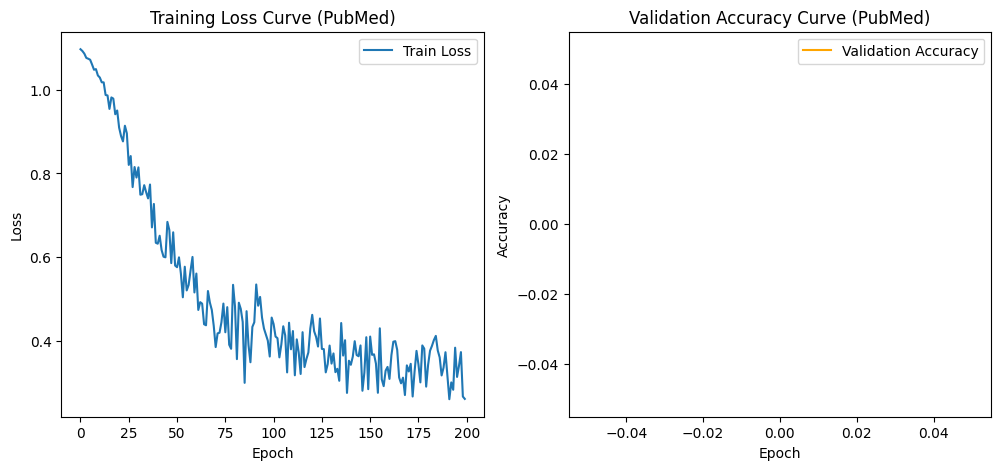

Test Accuracy on PubMed: 0.7660


In [9]:

train_and_evaluate("PubMed", False)